Simple RNN단점 : 장기 의존성 문제

장기 의존성 문제 : 입력 데이터가 많아 질수록 SimpleRNN레이어, 즉 은닉 층에서 보관하는 과거의 정보가 마지막 레이어까지 충분히 전달되지 못하는 현상

LSTM 레이어 : 시간 t에서의 출력값 Ht 이외에, LSTM레이어 사이에서 공유되는 셀 상태(cell state)Ct라는 변수가 추가적으로 공유되는 특징이 있음

LSTM 핵심 : 이전 단계 정보를 memory cell에 저장하여 다음 단계로 전달하는 것임

삼성전자 주식가격 예측(2000-01-04~2021-06-18)

주식데이터가 시계열데이터라고 가정하고 예측

In [5]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

[1] 데이터 로드 및 분포 확인

In [41]:
finance = pd.read_csv('./data/005930.KS.csv')

# 앞 3일의 평균
finance['3MA'] = finance['Adj Close'].rolling(3).mean()

# 앞 5일의 평균
finance['5MA'] = finance['Adj Close'].rolling(5).mean()

In [42]:
finance.head()

,Date,Open,High,Low,Close,Adj Close,Volume,3MA,5MA
0,2000-01-04,6000.0,6110.0,5660.0,6110.0,4563.383789,74195000,NaN,NaN
1,2000-01-05,5800.0,6060.0,5520.0,5580.0,4167.542969,74680000,NaN,NaN
2,2000-01-06,5750.0,5780.0,5580.0,5620.0,4197.416992,54390000,4309.447917,NaN
3,2000-01-07,5560.0,5670.0,5360.0,5540.0,4137.667969,40305000,4167.542643,NaN
4,2000-01-10,5600.0,5770.0,5580.0,5770.0,4309.448730,46880000,4214.844564,4275.09209


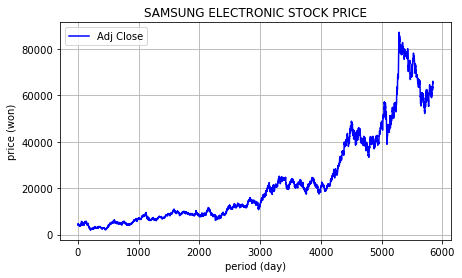

In [43]:
plt.figure(figsize=(7, 4))

plt.title('SAMSUNG ELECTRONIC STOCK PRICE')
plt.ylabel('price (won)')
plt.xlabel('period (day)')
plt.grid()

plt.plot(finance['Adj Close'], label='Adj Close', color='b')
plt.legend(loc='best')

plt.show()

LSTM을 이용하여 20년간의 주가 데이터를 학습하고 그 뒤를 예측

[2] 데이터 전처리

In [44]:
# 이상치 확인

finance.describe()
# 주식과 같은 금융데이터에서 Volume(거래량)값이 없는, 즉 0으로 나타나는 곳은 missing value(결측값)인 NaN으로 취급하는 것이 일반적

,Open,High,Low,Close,Adj Close,Volume,3MA,5MA
count,5844.000000,5844.000000,5844.000000,5844.000000,5844.000000,5.844000e+03,5842.000000,5840.000000
mean,26233.239220,26493.918549,25965.847023,26227.012320,22783.017697,2.142574e+07,22778.858379,22774.653713
std,20860.017097,21028.804605,20681.153275,20843.814212,20377.741257,1.529895e+07,20369.551522,20361.684801
min,2540.000000,2760.000000,2420.000000,2730.000000,2038.958740,0.000000e+00,2083.771037,2098.708496
25%,10375.000000,10520.000000,10260.000000,10400.000000,7872.025391,1.172968e+07,7877.003703,7889.395947
50%,17870.000000,18020.000000,17670.000000,17870.000000,14120.687500,1.737548e+07,14119.659180,14144.406934
75%,41112.500000,41542.500000,40850.000000,41210.000000,35405.623047,2.659555e+07,35464.105143,35411.350391
max,90300.000000,96800.000000,89500.000000,91000.000000,87219.484375,1.642150e+08,86676.354167,86222.682813


In [45]:
# 결측치 확인

finance.isnull().sum()
# 주식과 같은 금융데이터에서 NaN으로 표시되는 missing value는 평균값이나 중간값 등으로 대체하지 않고 해당되는 행(row) 전체를 삭제하는 것이 일반적

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
3MA          2
5MA          4
dtype: int64

In [46]:
# Volume값 0을 모두 NaN으로 대체

finance['Volume'] = finance['Volume'].replace(0, np.nan)

# 각 column의 0 개수 확인
for col in finance.columns:
    missing_rows = finance.loc[finance[col] == 0].shape[0]
    print(col + ' : ' + str(missing_rows))

Date : 0
Open : 0
High : 0
Low : 0
Close : 0
Adj Close : 0
Volume : 0
3MA : 0
5MA : 0


In [47]:
# 모든 missing value 삭제

finance.isnull().sum()

Date           0
Open           0
High           0
Low            0
Close          0
Adj Close      0
Volume       127
3MA            2
5MA            4
dtype: int64

In [48]:
finance = finance.dropna()
finance.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
3MA          0
5MA          0
dtype: int64

In [49]:
finance.head()

,Date,Open,High,Low,Close,Adj Close,Volume,3MA,5MA
4,2000-01-10,5600.0,5770.0,5580.0,5770.0,4309.448730,46880000.0,4214.844564,4275.092090
5,2000-01-11,5820.0,6100.0,5770.0,5770.0,4309.448730,59745000.0,4252.188476,4224.305078
6,2000-01-12,5610.0,5740.0,5600.0,5720.0,4272.104492,29220000.0,4297.000651,4245.217383
7,2000-01-13,5600.0,5740.0,5560.0,5710.0,4264.635742,41190000.0,4282.062988,4258.661133
8,2000-01-14,5720.0,5880.0,5680.0,5830.0,4354.259766,49375000.0,4297.000000,4301.979492


In [50]:
# 딥러닝 학습이 잘되기 위해서는 정규화 작업이 필요
# 즉 날짜를 나타내는 Date항목을 제외한 숫자로 표현되는 모든 column에 대해서 0~1값으로 정규화 수행

# 데이터 전처리 - 정규화
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

scale_cols = ['Open', 'High', 'Low', 'Close', 'Adj Close', '3MA', '5MA', 'Volume'] # 정규화 대상 column 정의

scaled_df = scaler.fit_transform(finance[scale_cols]) # 정규화 수행

print(type(scaled_df), '\n') # fin_transform의 return값이 numpy

scaled_df = pd.DataFrame(scaled_df, columns = scale_cols) # 정규화된 새로운 DataFrame생성

print(scaled_df)

<class 'numpy.ndarray'> 

          Open      High       Low     Close  Adj Close       3MA       5MA  \
0     0.034868  0.032008  0.036288  0.034440   0.026655  0.025192  0.025698   
1     0.037375  0.035517  0.038470  0.034440   0.026655  0.025634  0.025094   
2     0.034982  0.031689  0.036518  0.033873   0.026217  0.026163  0.025343   
3     0.034868  0.031689  0.036059  0.033760   0.026129  0.025987  0.025503   
4     0.036235  0.033177  0.037437  0.035120   0.027181  0.026163  0.026018   
...        ...       ...       ...       ...        ...       ...       ...   
5708  0.709435  0.675670  0.715204  0.713379   0.747366  0.735875  0.736976   
5709  0.725387  0.674607  0.723243  0.715645   0.749714  0.750061  0.742445   
5710  0.720830  0.674607  0.722095  0.716778   0.750888  0.754001  0.747439   
5711  0.718551  0.673543  0.723243  0.717911   0.752062  0.755577  0.756475   
5712  0.729945  0.678860  0.718650  0.706582   0.740322  0.752425  0.756712   

        Volume  
0     0.

In [51]:
# feature columns / label column 정의

# 딥러닝 학습을 위한 입력데이터 feature column, 정답 데이터 label column 정의 후  numpy로 변환하여 데이터 전처리 과정 완료

feature_cols = ['3MA', '5MA', 'Adj Close'] # feature 정의(입력 데이터)
label_cols = ['Adj Close'] # label 정의(정답 데이터)

label_df = pd.DataFrame(scaled_df, columns = label_cols)
feature_df = pd.DataFrame(scaled_df, columns = feature_cols)

print(feature_df)
print(label_df)

label_np = label_df.to_numpy() # 딥러닝 학습을 위해 DataFrame -> numpy 변환
feature_np = feature_df.to_numpy()

           3MA       5MA  Adj Close
0     0.025192  0.025698   0.026655
1     0.025634  0.025094   0.026655
2     0.026163  0.025343   0.026217
3     0.025987  0.025503   0.026129
4     0.026163  0.026018   0.027181
...        ...       ...        ...
5708  0.735875  0.736976   0.747366
5709  0.750061  0.742445   0.749714
5710  0.754001  0.747439   0.750888
5711  0.755577  0.756475   0.752062
5712  0.752425  0.756712   0.740322

[5713 rows x 3 columns]
      Adj Close
0      0.026655
1      0.026655
2      0.026217
3      0.026129
4      0.027181
...         ...
5708   0.747366
5709   0.749714
5710   0.750888
5711   0.752062
5712   0.740322

[5713 rows x 1 columns]


In [52]:
# 입력 파라미터 feature, label => numpy type

def make_sequence_dataset(feature, label, window_size):
    
    feature_list = [] # 생성될 feature_list
    label_list = []     # 생성될 label_list
    
    for i in range(len(feature) - window_size):
        
        feature_list.append(feature[i:i+window_size])
        label_list.append(label[i+window_size])
        
    return np.array(feature_list), np.array(label_list)
    # feature_list = [[..], [..], [..], ..] 이므로 리턴 값 np.array(feature_list)는 (batch_size, time_steps, input_dims) 형상을 가짐

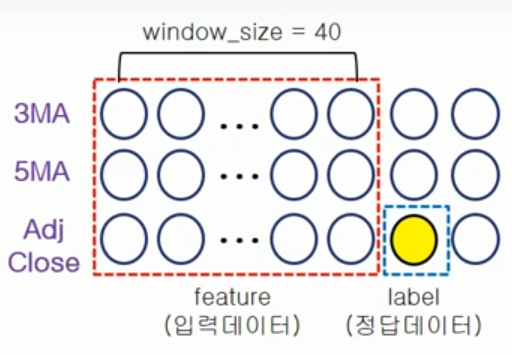

In [54]:
# 학습데이터 X, Y 생성

window_size = 40

X, Y  = make_sequence_dataset(feature_np, label_np, window_size)

print(X.shape, Y.shape)

(5673, 40, 3) (5673, 1)


In [56]:
# 트레이닝 데이터 / 테스트 데이터 분리
split = -200

x_train = X[0 : split]
y_train = Y[0 : split]

x_test = X[split:]
y_test = Y[split:]

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)
# train data 5473, test 200

(5473, 40, 3) (5473, 1)
(200, 40, 3) (200, 1)


In [57]:
# LSTM 모델 구축

model = Sequential()

model.add(LSTM(128,
                             activation='tanh', # LSTM계층에 tanh를 활성화 함수로 가지는 노드 수 128개 
                             input_shape=x_train[0].shape)) # input_shape = (40, 3) 40개의 데이터로 미래 값 예측

model.add(Dense(1, activation='linear'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128)               67584     
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 67,713
Trainable params: 67,713
Non-trainable params: 0
_________________________________________________________________


In [60]:
# 모델 컴파일 및 학습

from tensorflow.keras.callbacks import EarlyStopping

model.compile(loss='mse', optimizer='adam', metrics=['mae'])

early_stop = EarlyStopping(monitor='val_loss', patience=5)

model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=100, batch_size=16, callbacks=[early_stop])

Epoch 1/100
343/343 [==============================] - 25s 59ms/step - loss: 6.4907e-04 - mae: 0.0110 - val_loss: 3.8300e-04 - val_mae: 0.0164
Epoch 2/100
343/343 [==============================] - 18s 54ms/step - loss: 1.3317e-04 - mae: 0.0071 - val_loss: 6.6172e-04 - val_mae: 0.0212
Epoch 3/100
343/343 [==============================] - 17s 49ms/step - loss: 1.2523e-04 - mae: 0.0069 - val_loss: 2.6049e-04 - val_mae: 0.0129
Epoch 4/100
343/343 [==============================] - 18s 53ms/step - loss: 1.1110e-04 - mae: 0.0066 - val_loss: 2.8490e-04 - val_mae: 0.0142
Epoch 5/100
343/343 [==============================] - 18s 52ms/step - loss: 1.0279e-04 - mae: 0.0064 - val_loss: 1.8706e-04 - val_mae: 0.0112
Epoch 6/100
343/343 [==============================] - 18s 53ms/step - loss: 9.0463e-05 - mae: 0.0060 - val_loss: 1.7852e-04 - val_mae: 0.0109
Epoch 7/100
343/343 [==============================] - 18s 53ms/step - loss: 7.8551e-05 - mae: 0.0056 - val_loss: 2.0471e-04 - val_mae: 0.0121

7/7 [==============================] - 1s 29ms/step


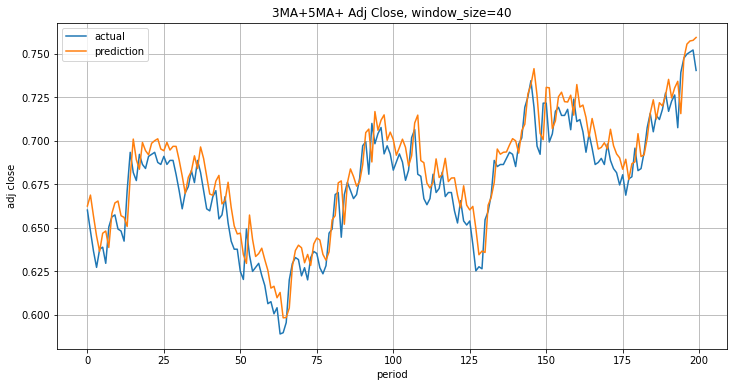

In [61]:
# 삼성전자 주가 예측

pred = model.predict(x_test)

plt.figure(figsize=(12, 6))
plt.title('3MA+5MA+ Adj Close, window_size=40')
plt.ylabel('adj close')
plt.xlabel('period')
plt.plot(y_test, label='actual')
plt.plot(pred, label='prediction')
plt.grid()
plt.legend(loc='best')

plt.show()

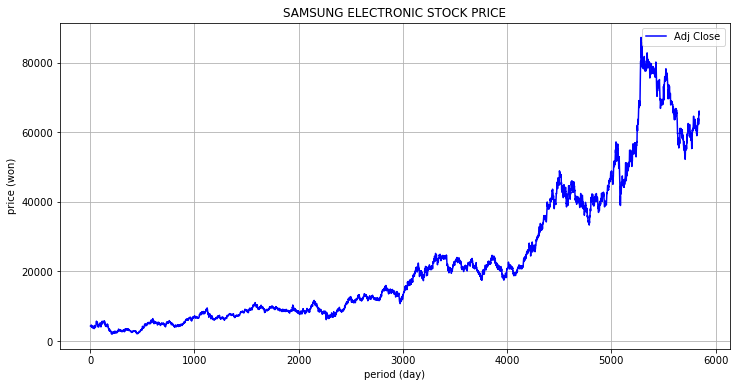

In [63]:
plt.figure(figsize=(12, 6))

plt.title('SAMSUNG ELECTRONIC STOCK PRICE')
plt.ylabel('price (won)')
plt.xlabel('period (day)')
plt.grid()

plt.plot(finance['Adj Close'], label='Adj Close', color='b')
plt.legend(loc='best')

plt.show()